# Inference model monitoring
In this notebook we will have a look at how to set up monitoring hooks for your inference models. The Geti SDK provides several basic triggers and actions that can be used to construct pipelines for, for instance, data collection, alerting, or other actions that need to take place based on inference results. 

These pipelines are referred to as `post inference hooks` and can be added to any `Deployment` for any project. In this notebook we will create a post inference hook that implements the following:

For every inferred frame or image, check if any of the predicted objects/labels have a low model confidence (i.e. probability < 55 %). If so, send the image to the Geti server. The image will be stored in a new dataset called `Inferred images`, within the original project.

In [1]:
# As usual we will connect to the platform first, using the server details from the .env file

from geti_sdk import Geti
from geti_sdk.utils import get_server_details_from_env

geti_server_configuration = get_server_details_from_env()

geti = Geti(server_config=geti_server_configuration)

C:\Users\ljcornel\PycharmProjects\sonoma_creek_sdk\geti_sdk\http_session\geti_session.py:77: InsecureRequestWarning: You have disabled TLS certificate validation, HTTPS requests made to the Intel® Geti™ server may be compromised. For optimal security, please enable certificate validation.
  warnings.warn(


2024-03-12 11:37:42,069 - INFO - Authenticating on host https://10.211.120.59...
2024-03-12 11:37:42,818 - INFO - Authentication successful. Cookie received.


## Selecting a project


In [2]:
PROJECT_NAME = "COCO animal detection demo"
project = geti.get_project(PROJECT_NAME)

## Create deployment for the project

In [3]:
deployment = geti.deploy_project(PROJECT_NAME)

2024-03-12 11:37:51,730 - INFO - Deployment for project 'COCO animal detection demo' started.
2024-03-12 11:37:51,750 - INFO - Waiting for the deployment to be created...
2024-03-12 11:37:53,397 - INFO - Downloading project deployment archive...
2024-03-12 11:37:55,696 - INFO - Deployment for project 'COCO animal detection demo' downloaded and extracted successfully.


## Checking deployment output

In [4]:
deployment.load_inference_models()

2024-03-12 11:37:55,903 - INFO - OpenVINO Runtime
2024-03-12 11:37:55,908 - INFO - 	build: 2023.0.0-10926-b4452d56304-releases/2023/0
2024-03-12 11:37:55,933 - INFO - Reading model C:\Users\ljcornel\AppData\Local\Temp\tmpbceerpte\deployment\Detection task\model\model.xml
2024-03-12 11:37:56,576 - WARNING - The parameter "result_based_confidence_threshold" not found in SSD wrapper, will be omitted
2024-03-12 11:37:56,580 - WARNING - The parameter "max_num_detections" not found in SSD wrapper, will be omitted
2024-03-12 11:37:56,581 - WARNING - The parameter "use_ellipse_shapes" not found in SSD wrapper, will be omitted
2024-03-12 11:38:00,284 - INFO - The model C:\Users\ljcornel\AppData\Local\Temp\tmpbceerpte\deployment\Detection task\model\model.xml is loaded to CPU
2024-03-12 11:38:00,287 - INFO - 	Device: CPU
2024-03-12 11:38:00,291 - INFO - 		Number of streams: 1
2024-03-12 11:38:00,294 - INFO - 		Number of threads: AUTO
2024-03-12 11:38:00,297 - INFO - 	Number of model infer reques

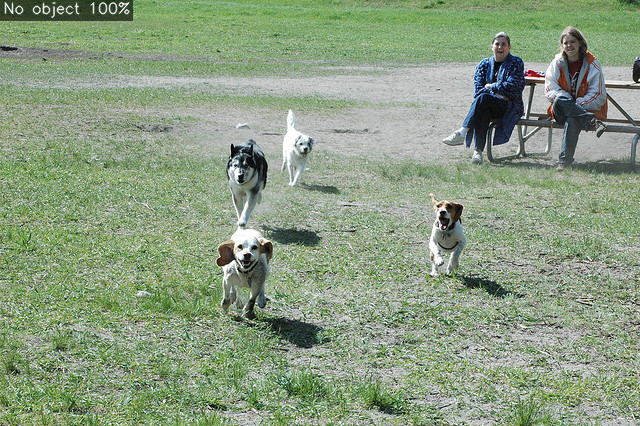

In [5]:
import cv2

from geti_sdk.demos import EXAMPLE_IMAGE_PATH
from geti_sdk.utils import show_image_with_annotation_scene

numpy_image = cv2.imread(EXAMPLE_IMAGE_PATH)
numpy_rgb = cv2.cvtColor(numpy_image, cv2.COLOR_BGR2RGB)

prediction = deployment.infer(numpy_rgb)

show_image_with_annotation_scene(numpy_rgb, prediction, show_in_notebook=True);

## Configuring a post inference hook to send image data to Geti

In [6]:
from geti_sdk.post_inference_hooks import (
    EmptyLabelTrigger,
    GetiDataCollection,
    PostInferenceHook,
)

trigger = EmptyLabelTrigger()
action = GetiDataCollection(
    session=geti.session,
    workspace_id=geti.workspace_id,
    project=project,
    dataset="Inferred images",
)
hook = PostInferenceHook(trigger=trigger, action=action, max_threads=0)

In [7]:
deployment.add_post_inference_hook(hook)

In [8]:
prediction = deployment.infer(numpy_rgb)

trigger.get_decision(trigger(numpy_rgb, prediction))

True

In [9]:
from geti_sdk.post_inference_hooks import (
    ConfidenceTrigger,
    FileSystemDataCollection,
    PostInferenceHook,
)

trigger2 = ConfidenceTrigger(threshold=1.1)
action2 = FileSystemDataCollection("hook_data")
hook2 = PostInferenceHook(trigger=trigger2, action=action2, max_threads=0)

In [10]:
deployment.add_post_inference_hook(hook2)

In [11]:
prediction = deployment.infer(numpy_rgb)

## Benchmarking inference hook runtime overhead



In [12]:
deployment_2 = geti.deploy_project(PROJECT_NAME)
deployment_2.load_inference_models()

2024-03-12 11:38:11,316 - INFO - Deployment for project 'COCO animal detection demo' started.
2024-03-12 11:38:11,336 - INFO - Waiting for the deployment to be created...
2024-03-12 11:38:12,932 - INFO - Downloading project deployment archive...
2024-03-12 11:38:13,983 - INFO - Deployment for project 'COCO animal detection demo' downloaded and extracted successfully.
2024-03-12 11:38:14,131 - INFO - OpenVINO Runtime
2024-03-12 11:38:14,135 - INFO - 	build: 2023.0.0-10926-b4452d56304-releases/2023/0
2024-03-12 11:38:14,154 - INFO - Reading model C:\Users\ljcornel\AppData\Local\Temp\tmpsjggmwm2\deployment\Detection task\model\model.xml
2024-03-12 11:38:14,681 - WARNING - The parameter "result_based_confidence_threshold" not found in SSD wrapper, will be omitted
2024-03-12 11:38:14,684 - WARNING - The parameter "max_num_detections" not found in SSD wrapper, will be omitted
2024-03-12 11:38:14,686 - WARNING - The parameter "use_ellipse_shapes" not found in SSD wrapper, will be omitted
2024

In [13]:
import time

from tqdm import tqdm

t_start = time.time()
for i in tqdm(range(100)):
    deployment_2.infer(numpy_rgb)
t_elapsed = time.time() - t_start
print(f"100 inference iterations without hooks completed in {t_elapsed:.2f} seconds.")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.23it/s]

100 inference iterations without hooks completed in 44.88 seconds.


In [14]:
trigger = EmptyLabelTrigger()
action = GetiDataCollection(
    session=geti.session,
    workspace_id=geti.workspace_id,
    project=project,
    dataset="Inferred images",
    log_level="debug",
)
geti_hook = PostInferenceHook(trigger=trigger, action=action, max_threads=8)

trigger2 = ConfidenceTrigger(threshold=1.1)
action2 = FileSystemDataCollection(
    target_folder="hook_data",
    save_predictions=False,
    save_scores=False,
    log_level="debug",
)
hook2 = PostInferenceHook(trigger=trigger2, action=action2, max_threads=8)

deployment_2.add_post_inference_hook(hook2)

In [15]:
t_start = time.time()
for i in tqdm(range(100)):
    deployment.infer(numpy_rgb)
t_elapsed = time.time() - t_start
print(f"100 inference iterations with hooks completed in {t_elapsed:.2f} seconds.")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]

100 inference iterations with hooks completed in 87.59 seconds.
